In [ ]:
import pandas as pd
import torch
import pymysql
from dotenv import load_dotenv
import os
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, pipeline
import requests


def retrieve(embedding, dataframe, embed_col_name='embedding', retrieve_num=5):
    """
    * Retrieve Funtion:
    ! Temporary using dataframe to store embeddings of items, will be replaced by database in the future. 
    ! Be cautious of the magnitude of the embeddings, as the cosine similarity is sensitive to it. A normalization step may be needed.
    * Usage : Retrieve the most similar item from dataset through cosine similarity of embeddings.
    * Input param:
        - 1. embdedding : Embedding of the item to be retrieved
        - 2. dataframe : Embedding of all items in a dataframe
    * Return : 
        - Dictionary of most similar items id and similarity score
            - key : item_id
            - value : similarity score
    """
    # Ensure embedding is a 1D tensor
    embedding_tensor = torch.tensor(embedding).flatten()

    # Calculate cosine similarity and convert to float
    result_seq = dataframe[embed_col_name].apply(
        lambda x: torch.nn.functional.cosine_similarity(
            embedding_tensor, torch.tensor(x).flatten(), dim=0
        ).item()  # Convert tensor to Python float
    )
    
    # Get the n most similar items
    result = result_seq.nlargest(retrieve_num)
    return dict(zip(result.index, result.values))


def load_test_df_from_db():
    # Load the data from database
    load_dotenv()
    db = pymysql.connect(
        host=os.getenv('DB_HOST'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD'),
        database='fashion_community',
        charset='utf8'
    )
    cursor = db.cursor(pymysql.cursors.DictCursor)
    cursor.execute(
        """
        SELECT item_id, img_url, feature
        FROM (
            SELECT *, ROW_NUMBER() OVER (PARTITION BY origin_label ORDER BY RAND()) AS row_num
            FROM classify_amazon
        ) AS ranked
        WHERE row_num <= 15;
        """
    )
    result = cursor.fetchall()
    db.close()
    # Put the result into dataframe
    df = pd.DataFrame(result)

    image_folder = r'C:\Users\95144\Desktop\Fashion Repository\Fashion-Community-Develop\Fashion Community\Images\Amazon\results'
    # Quick access through image url
    # df['image'] = df['img_url'].apply(lambda x: Image.open(requests.get(x, stream=True).raw))

    # images is saved in image_folder with a .jpg extension
    df['image'] = df['img_url'].apply(lambda x: Image.open(f'{image_folder}/{x}.jpg'))


    return df

def tokenizer_check_summary(text, 
                            processor=CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32"), 
                            summarizer=pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=0 if torch.cuda.is_available() else -1),
                            max_length=70):
    
    tokenizer = processor.tokenizer
    tokens = tokenizer(text, truncation=False, return_tensors="pt")

    if tokens.input_ids.shape[1] > max_length:  # Text exceeds max token length
        try:
            summary = summarizer(text, max_length=32, min_length=24, do_sample=False)
            text = summary[0]['summary_text']
        except Exception as e:
            print(f"Summarization failed for text: {text}: {e}. Truncating text.")
            text = text[:max_length]  # Fallback truncation if summarization fails

    return text



def embedding_clip(text: str, 
                   device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                   model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32"),
                   processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")):
    """
    * Embedding Function:
    * Usage : Embedding the text through pre-trained model.
    * Input param:
        - text : Text to be embedded
    * Return :
        - Embedding of the prompt
    ! Initialize the model out of the function in future
    """
    model.to(device)
    model.eval()
    summarized_input = tokenizer_check_summary(text)
    text_input = processor(summarized_input, return_tensors="pt", padding=True)
    text_input = {k: v.to(device) for k, v in text_input.items()}

    with torch.no_grad():
        text_feature = model.get_text_features(**text_input)
    
    return text_feature


def embedding_clip_image(image: Image, 
                         device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                         model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32"),
                         processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")):
    
    model.to(device)
    model.eval()
    image_input = processor(images=image, return_tensors="pt", padding=True)
    image_input = {k: v.to(device) for k, v in image_input.items()}

    with torch.no_grad():
        image_feature = model.get_image_features(**image_input)
    
    return image_feature

def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
# Load db
df_test = load_test_df_from_db()
# Get embeddings then save to df
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_test['text_embedding'] = df_test['feature'].apply(lambda x: embedding_clip(x, device))
df_test['image_embedding'] = df_test['image'].apply(lambda x: embedding_clip_image(x, device))
df_test.to_csv('test_df.csv', index=False)

In [ ]:
prompt = "korean style"

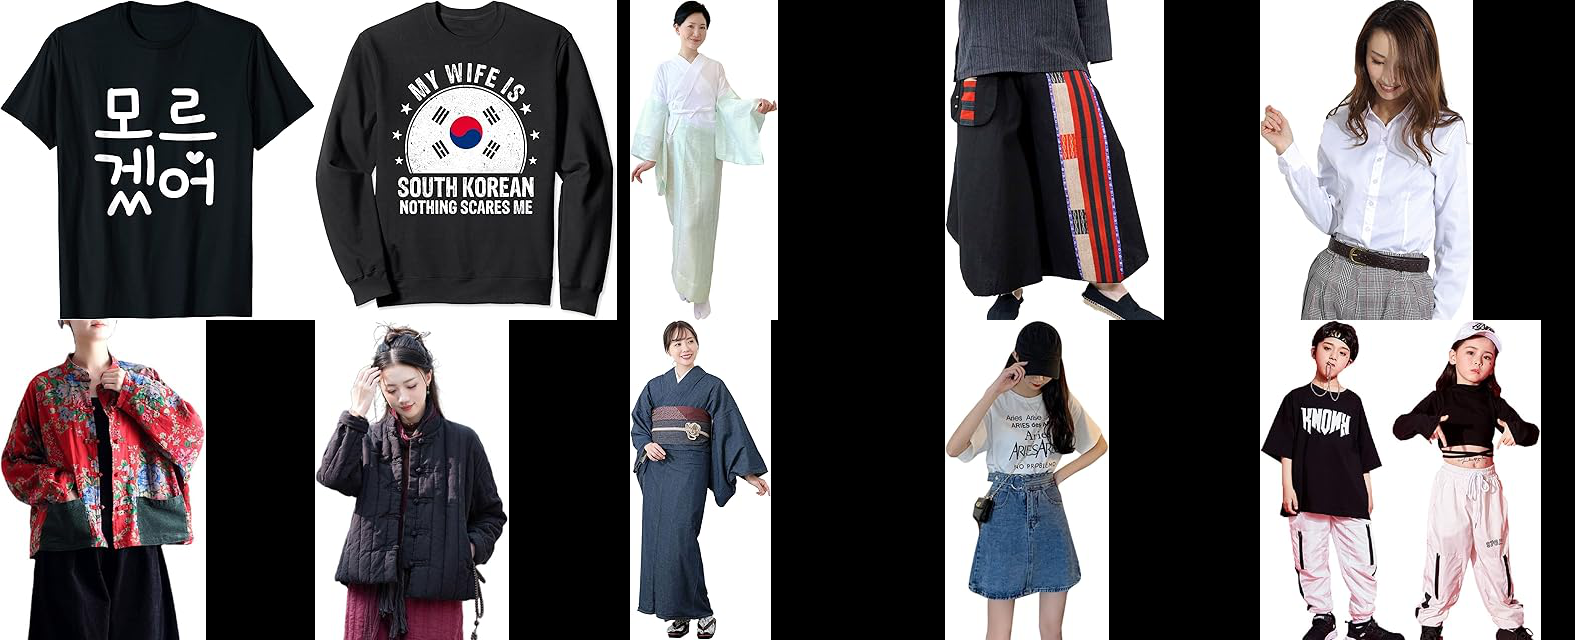

In [ ]:
embed = embedding_clip(prompt)
result_dict = retrieve(embed,df_test,embed_col_name='image_embedding', retrieve_num=10)
images = []
for item in result_dict.keys():
    images.append(df_test.loc[item, 'image'])

grid = image_grid(images, cols=5)
display(grid)